In [1]:
# use pytorch_2024 (deprecated: use gpd_2023 environment)
import os
import pickle
import numpy as np
import pandas as pd
import torch    
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# now get AUROC and average precision for the probas and mse for the ln's
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, brier_score_loss

from datetime import datetime

import sys
from pathlib import Path

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) #Path("/home/simon/Documents/scripts/views_pipeline/models/purple_alien/notebooks/test_to_prediction_store.ipynb")

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("views_pipeline")+1]]) / "common_utils")) # PATH_COMMON_UTILS  
from set_path import setup_project_paths, setup_data_paths
setup_project_paths(PATH)

# now import the local functions
from utils_df_to_vol_conversion import df_to_vol, df_vol_conversion_test, plot_vol
from utils_wandb import generate_wandb_log_dict 
from utils_evaluation_metrics import EvaluationMetrics
from utils_model_outputs import ModelOutputs
from utils_hydranet_outputs import output_to_df, evaluation_to_df, plot_metrics
from utils_date_index import calculate_date_from_index
from utils import get_full_tensor

from persistence_model_class import PersistenceModel

# Summery of all 12 models

In [2]:
# crate empty dfs for the evaluation metrics, there should be a different one for each metric and feature (sb, ns, os) and for with and without middle east
# there are 12 models in total

def get_multi_model_evalution_dfs(feature = 'sb', include_middle_east = True):

    # make the model "names" from 01 to 12 insure the zero padding for single digits!!!
    array_of_steps = np.arange(1, 37)
    list_of_models_identifiers = [f"model_{i:02d}" for i in range(1, 13)]

    # start with one df.... All inherantly feature specific
    df_ap = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_mse = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_auc = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_brier = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)


    # fill in the step column with numbers from 1 to 36
    df_ap["step"] = array_of_steps
    df_mse["step"] = array_of_steps
    df_auc["step"] = array_of_steps
    df_brier["step"] = array_of_steps

    list_of_PATHS_df_outs = ["/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_105456.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_120632.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_134131.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_145928.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_155842.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_174827.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_202616.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_214859.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_231311.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_002248.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_070340.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_102826.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_121411.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_141514.pkl",
                                "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240808_153736.pkl",
                             ]

    for i, j in enumerate(list_of_PATHS_df_outs):

        df = pd.read_pickle(j)

        if not include_middle_east:
            middle_east_c_id = [ 0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0, 218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0]
            df = df[~df["c_id"].isin(middle_east_c_id)].copy()

        mse_list = []
        ap_list = []
        auc_list = []
        brier_list = []

        for step in array_of_steps:  

            y_score = df[df["step"] == step][f"y_score_{feature}"]
            y_score_prob = df[df["step"] == step][f"y_score_prob_{feature}"]
            y_true = df[df["step"] == step][f"y_true_sb"]
            y_true_binary = df[df["step"] == step][f"y_true_binary_{feature}"]


            mse = mean_squared_error(y_true, y_score)
            ap = average_precision_score(y_true_binary, y_score_prob)
            auc = roc_auc_score(y_true_binary, y_score_prob)
            brier = brier_score_loss(y_true_binary, y_score_prob)

            mse_list.append(mse)
            ap_list.append(ap)
            auc_list.append(auc)
            brier_list.append(brier)

        # a bit hacky naming but it works fine
        df_mse[f"model_{i+1:02d}_{j[-19:-4]}"] = mse_list
        df_ap[f"model_{i+1:02d}_{j[-19:-4]}"] = ap_list
        df_auc[f"model_{i+1:02d}_{j[-19:-4]}"] = auc_list
        df_brier[f"model_{i+1:02d}_{j[-19:-4]}"] = brier_list

    return df_ap, df_mse, df_auc, df_brier

In [3]:
# sb with middle east and without
df_ap_sb_me, df_mse_sb_me, df_auc_sb_me, df_brier_sb_me = get_multi_model_evalution_dfs(feature = 'sb', include_middle_east = True)
df_ap_sb_no_me, df_mse_sb_no_me, df_auc_sb_no_me, df_brier_sb_no_me = get_multi_model_evalution_dfs(feature = 'sb', include_middle_east = False)

# os with middle east and without
df_ap_os_me, df_mse_os_me, df_auc_os_me, df_brier_os_me = get_multi_model_evalution_dfs(feature = 'os', include_middle_east = True)
df_ap_os_no_me, df_mse_os_no_me, df_auc_os_no_me, df_brier_os_no_me = get_multi_model_evalution_dfs(feature = 'os', include_middle_east = False)

# ns with middle east and without
df_ap_ns_me, df_mse_ns_me, df_auc_ns_me, df_brier_ns_me = get_multi_model_evalution_dfs(feature = 'ns', include_middle_east = True)
df_ap_ns_no_me, df_mse_ns_no_me, df_auc_ns_no_me, df_brier_ns_no_me = get_multi_model_evalution_dfs(feature = 'ns', include_middle_east = False)

In [4]:
df_mse_sb_me.head()

,step,model_01_20240807_105456,model_02_20240807_120632,model_03_20240807_134131,model_04_20240807_145928,model_05_20240807_155842,model_06_20240807_174827,model_07_20240807_202616,model_08_20240807_214859,model_09_20240807_231311,model_10_20240808_002248,model_11_20240808_070340,model_12_20240808_102826,model_13_20240808_121411,model_14_20240808_141514,model_15_20240808_153736
0,1,0.008837,0.007882,0.007957,0.011244,0.007564,0.008336,0.008740,0.008237,0.007722,0.008114,0.007665,0.011417,0.008867,0.008365,0.007396
1,2,0.008311,0.006741,0.007077,0.012504,0.006817,0.007344,0.008698,0.007452,0.006666,0.007419,0.006302,0.012527,0.007610,0.007842,0.006389
2,3,0.011557,0.009078,0.011042,0.019271,0.010239,0.011737,0.011402,0.009593,0.009105,0.010950,0.009298,0.021004,0.011488,0.010217,0.008670
3,4,0.010384,0.007950,0.009253,0.020903,0.008947,0.009837,0.011211,0.009132,0.008599,0.010465,0.008060,0.026609,0.010542,0.010169,0.007912
4,5,0.009634,0.007933,0.007621,0.025201,0.008031,0.010065,0.009426,0.007295,0.007109,0.011279,0.006408,0.036737,0.011451,0.008155,0.006754


In [5]:
df_ap_sb_me.head()

,step,model_01_20240807_105456,model_02_20240807_120632,model_03_20240807_134131,model_04_20240807_145928,model_05_20240807_155842,model_06_20240807_174827,model_07_20240807_202616,model_08_20240807_214859,model_09_20240807_231311,model_10_20240808_002248,model_11_20240808_070340,model_12_20240808_102826,model_13_20240808_121411,model_14_20240808_141514,model_15_20240808_153736
0,1,0.574509,0.577383,0.553469,0.585456,0.570053,0.582193,0.547004,0.585281,0.576465,0.565333,0.577266,0.560827,0.554189,0.570640,0.576220
1,2,0.569175,0.582394,0.569921,0.592964,0.595796,0.597645,0.566616,0.599392,0.600448,0.585534,0.600674,0.573258,0.588831,0.582432,0.591189
2,3,0.573136,0.567949,0.560904,0.573163,0.565013,0.563672,0.557105,0.561820,0.547465,0.557167,0.565953,0.540251,0.563405,0.552906,0.570158
3,4,0.571822,0.588187,0.541624,0.553789,0.563225,0.578928,0.552010,0.571226,0.562475,0.570808,0.566996,0.568151,0.564995,0.526421,0.575649
4,5,0.569522,0.574643,0.574991,0.570645,0.601217,0.574170,0.549691,0.590309,0.590971,0.558412,0.574894,0.565880,0.590712,0.583877,0.588824


In [6]:
df_ap_sb_me.mean(axis = 0).sort_values(ascending = False)

step                        18.500000
model_02_20240807_120632     0.466531
model_11_20240808_070340     0.458026
model_13_20240808_121411     0.453959
model_15_20240808_153736     0.453839
model_08_20240807_214859     0.451274
model_05_20240807_155842     0.450937
model_04_20240807_145928     0.448875
model_06_20240807_174827     0.447354
model_09_20240807_231311     0.443967
model_10_20240808_002248     0.442627
model_03_20240807_134131     0.435298
model_01_20240807_105456     0.428468
model_07_20240807_202616     0.426731
model_14_20240808_141514     0.424776
model_12_20240808_102826     0.412028
dtype: float64

In [36]:
# df without the fist column
df_ap_ns_me[df_ap_ns_me.columns[1:]].mean(axis = 0).sort_values(ascending = False)

model_06_20240807_174827    0.357238
model_10_20240808_002248    0.351701
model_13_20240808_121411    0.347906
model_11_20240808_070340    0.344377
model_15_20240808_153736    0.333328
model_03_20240807_134131    0.329056
model_02_20240807_120632    0.327475
model_05_20240807_155842    0.312206
model_09_20240807_231311    0.296844
model_04_20240807_145928    0.296759
model_14_20240808_141514    0.293594
model_07_20240807_202616    0.290048
model_01_20240807_105456    0.285052
model_08_20240807_214859    0.255876
model_12_20240808_102826    0.153165
dtype: float64

In [60]:
def analyze_model_performance(df, metric_name="Metric", model_type = "median", verbose = True):
    """
    Analyze model performance metrics by ranking means, calculating the median, 
    identifying the model with the median performance, and calculating the standard deviation.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing model performance metrics.
    metric_name (str): A string representing the name of the metric being analyzed (e.g., "AP", "MSE").
    model_type (str): A string representing the type of model to analyze. Options include "median" (default), "best", and "worst".
    verbose (bool): A boolean indicating whether to print the all analysis results.
    
    Returns:
    None: Prints the analysis results, including ranked means, the median, the model with the median performance, and the standard deviation.
    """
    # Rank the means from highest to lowest
    ranked_means = df[df.columns[1:]].mean(axis=0).sort_values(ascending=False)

    # Calculate the median of the means, excluding the highest value

    if model_type == "median":
        central_metric_value = np.median(ranked_means)

    elif model_type == "best":
        central_metric_value = ranked_means.max()

    elif model_type == "worst":
        central_metric_value = ranked_means.min()

    if verbose:
        print(f"Ranked Means (Highest to Lowest) - {metric_name}:")
        print(ranked_means)
        print("\n")

        print(f"Median of Ranked {metric_name}: {central_metric_value}")
        print("\n")

    # Identify the model(s) with the median performance
    model_mask = ranked_means.values == central_metric_value
    model_name = ranked_means.index[model_mask]
    print(f"Model(s) with the Median {metric_name}: {model_name.tolist()}")

    # Print the metric for the model with the median performance
    model_metric = ranked_means[model_mask]
    
    print(f"{metric_name} for the Model with Median Performance: {model_metric.values[0]}")

    # Calculate and print the standard deviation of the means, excluding the highest value
    std_dev = ranked_means.values.std()
    print(f"Standard Deviation of Ranked {metric_name}: {std_dev}")
    print("\n")


In [65]:
# Define a list of tuples containing DataFrame-variable names and corresponding metric names
analysis_configs = [
    (df_ap_sb_me, "AP"),
    (df_mse_sb_me, "MSE"),
    (df_auc_sb_me, "AUC"),
    (df_brier_sb_me, "Brier"),
    
    (df_ap_sb_no_me, "AP"),
    (df_mse_sb_no_me, "MSE"),
    (df_auc_sb_no_me, "AUC"),
    (df_brier_sb_no_me, "Brier"),
    
    (df_ap_os_me, "AP"),
    (df_mse_os_me, "MSE"),
    (df_auc_os_me, "AUC"),
    (df_brier_os_me, "Brier"),
    
    (df_ap_os_no_me, "AP"),
    (df_mse_os_no_me, "MSE"),
    (df_auc_os_no_me, "AUC"),
    (df_brier_os_no_me, "Brier"),
    
    (df_ap_ns_me, "AP"),
    (df_mse_ns_me, "MSE"),
    (df_auc_ns_me, "AUC"),
    (df_brier_ns_me, "Brier"),
    
    (df_ap_ns_no_me, "AP"),
    (df_mse_ns_no_me, "MSE"),
    (df_auc_ns_no_me, "AUC"),
    (df_brier_ns_no_me, "Brier")
]

# Loop through the analysis configurations and run the analysis for each one
for df, metric_name in analysis_configs:
    analyze_model_performance(df, metric_name, model_type="median", verbose=False)
    print("="*50)  # Separator for clarity in the output


Model(s) with the Median AP: ['model_06_20240807_174827']
AP for the Model with Median Performance: 0.4473540236555512
Standard Deviation of Ranked AP: 0.014211853544277342


Model(s) with the Median MSE: ['model_14_20240808_141514']
MSE for the Model with Median Performance: 0.010230078584254032
Standard Deviation of Ranked MSE: 0.023826709137267


Model(s) with the Median AUC: ['model_14_20240808_141514']
AUC for the Model with Median Performance: 0.9450298292075959
Standard Deviation of Ranked AUC: 0.002089927192539083


Model(s) with the Median Brier: ['model_05_20240807_155842']
Brier for the Model with Median Performance: 0.011315358155778166
Standard Deviation of Ranked Brier: 0.00227217787553361


Model(s) with the Median AP: ['model_09_20240807_231311']
AP for the Model with Median Performance: 0.2975588045504918
Standard Deviation of Ranked AP: 0.011945011214920712


Model(s) with the Median MSE: ['model_09_20240807_231311']
MSE for the Model with Median Performance: 0.003800

# No change/persitance model

In [8]:
PATH_df_output = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_120632.pkl"
PATH_df_test = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/testing_viewser_df.pkl"

# load the dataframes
df_output = pd.read_pickle(PATH_df_output)
df_test = pd.read_pickle(PATH_df_test)

In [9]:
# get the persistence model
persistence_model = PersistenceModel(df_test, ['ln_sb_best', 'ln_os_best', 'ln_ns_best'], is_true_forecast=False)
df_persistence = persistence_model.get_persistence_model_predictions()
df_persistence


[Validation/Evaluation (Adjusted 36 months earlier)] The max month is 12.2015 with month_id 432. Ensure this corresponds to your expectations! Current date is 08.2024.


,pg_id,ln_sb_best_persistence,ln_os_best_persistence,ln_ns_best_persistence,step
13110,62356,0.0,0.0,0.0,1
13111,79599,0.0,0.0,0.0,1
13112,79600,0.0,0.0,0.0,1
13113,79601,0.0,0.0,0.0,1
13114,80317,0.0,0.0,0.0,1
...,...,...,...,...,...
485065,190496,0.0,0.0,0.0,36
485066,190507,0.0,0.0,0.0,36
485067,190508,0.0,0.0,0.0,36
485068,190510,0.0,0.0,0.0,36


In [10]:
df_full = df_output.merge(df_persistence, on = ["pg_id", "step"], how = "left")

In [11]:
def get_persistence_model_dfs(df, feature = 'sb', include_middle_east = True):

    # make the model "names" from 01 to 12 insure the zero padding for single digits!!!
    array_of_steps = np.arange(1, 37)

    # start with one df.... All inherantly feature specific
    df_ap = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_mse = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_auc = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)
    df_brier = pd.DataFrame() #columns = ['step'] + list_of_models_identifiers)

    # fill in the step column with numbers from 1 to 36
    df_ap["step"] = array_of_steps
    df_mse["step"] = array_of_steps
    df_auc["step"] = array_of_steps
    df_brier["step"] = array_of_steps


    if not include_middle_east:
        middle_east_c_id = [ 0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0, 218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0]
        df = df[~df["c_id"].isin(middle_east_c_id)].copy()

    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    for step in array_of_steps:  

        y_score = df[df["step"] == step][f"ln_{feature}_best_persistence"]

        # I use the min and max of the y_score to normalise the predictions to mimic the probas - there are other ways to do this but is not trash...
        min_score = y_score.min()
        max_score = y_score.max()
        y_score_prob = (y_score - min_score) / (max_score - min_score)

        #check that y_score_prob is between 0 and 1 and throw an error if not
        if y_score_prob.min() < 0 or y_score_prob.max() > 1:
            raise ValueError("The probability predictions are not between 0 and 1")
            
        #y_score_prob = df[df["step"] == step][f"y_score_prob_{feature}"]

        y_true = df[df["step"] == step][f"y_true_sb"]
        y_true_binary = df[df["step"] == step][f"y_true_binary_{feature}"]


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        mse_list.append(mse)
        ap_list.append(ap)
        auc_list.append(auc)
        brier_list.append(brier)

    # a bit hacky naming but it works fine
    df_mse[f"MSE"] = mse_list
    df_ap[f"AP"] = ap_list
    df_auc[f"AUC"] = auc_list
    df_brier[f"brier"] = brier_list

    return df_ap, df_mse, df_auc, df_brier

In [12]:
df_ap_sb_me_persistence, df_mse_sb_me_persistence, df_auc_sb_me_persistence, df_brier_sb_me_persistence = get_persistence_model_dfs(df_full, feature = 'sb', include_middle_east = True)
df_ap_ns_me_persistence, df_mse_ns_me_persistence, df_auc_ns_me_persistence, df_brier_ns_me_persistence = get_persistence_model_dfs(df_full, feature = 'ns', include_middle_east = True)
df_ap_os_me_persistence, df_mse_os_me_persistence, df_auc_os_me_persistence, df_brier_os_me_persistence = get_persistence_model_dfs(df_full, feature = 'os', include_middle_east = True)

df_ap_sb_no_me_persistence, df_mse_sb_no_me_persistence, df_auc_sb_no_me_persistence, df_brier_sb_no_me_persistence = get_persistence_model_dfs(df_full, feature = 'sb', include_middle_east = False)
df_ap_ns_no_me_persistence, df_mse_ns_no_me_persistence, df_auc_ns_no_me_persistence, df_brier_ns_no_me_persistence = get_persistence_model_dfs(df_full, feature = 'ns', include_middle_east = False)
df_ap_os_no_me_persistence, df_mse_os_no_me_persistence, df_auc_os_no_me_persistence, df_brier_os_no_me_persistence = get_persistence_model_dfs(df_full, feature = 'os', include_middle_east = False)

In [13]:
df_ap_sb_no_me_persistence


,step,AP
0,1,0.176980
1,2,0.159842
2,3,0.200443
3,4,0.165540
4,5,0.149474
5,6,0.187108
6,7,0.162584
7,8,0.130580
8,9,0.160185
9,10,0.180503


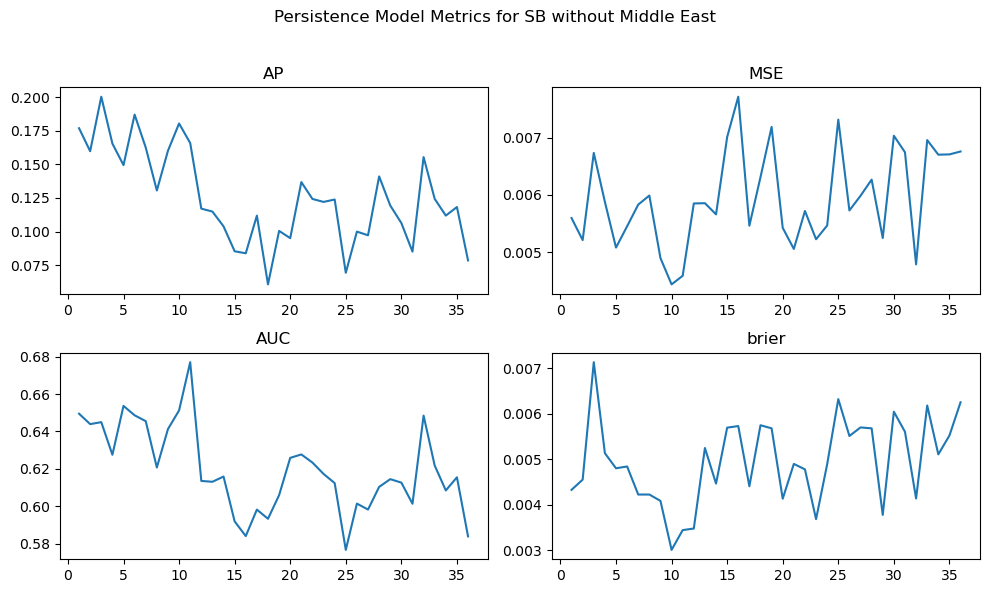

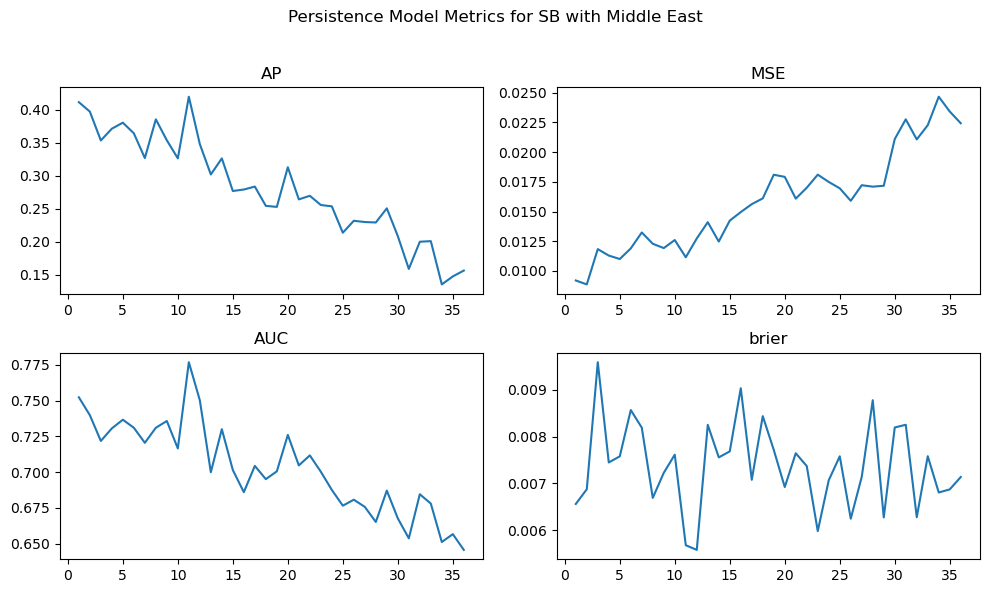

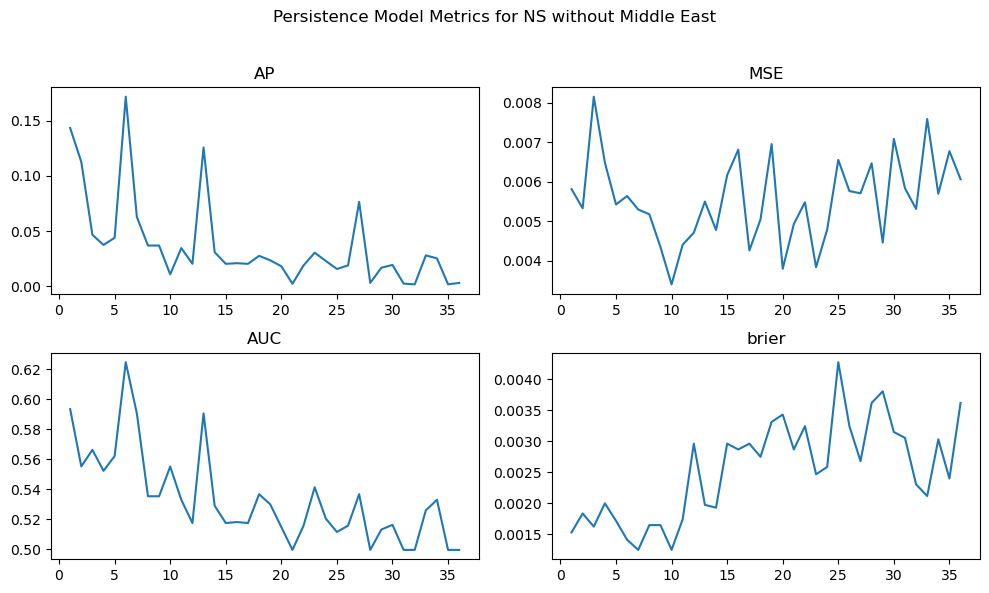

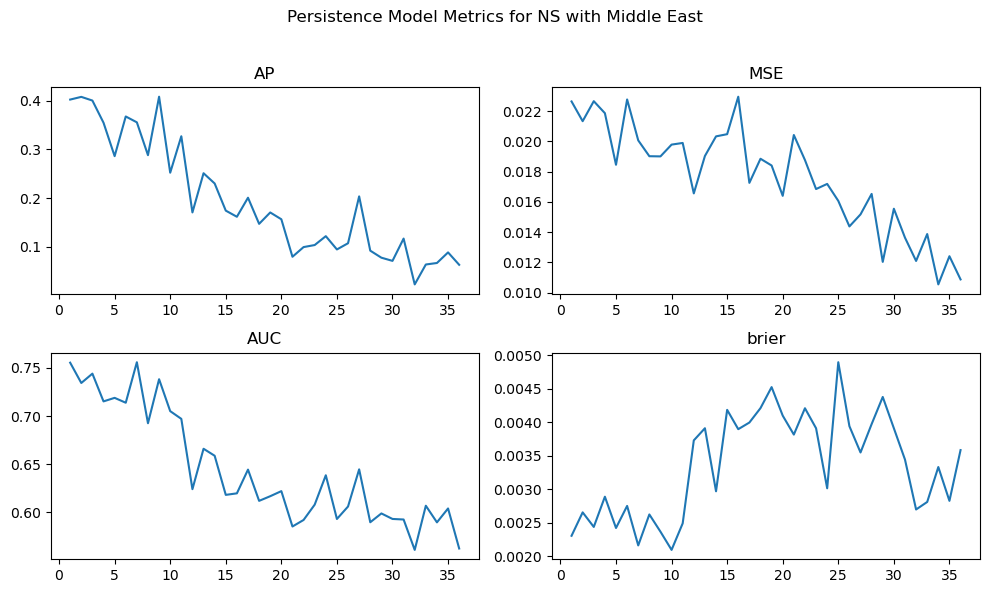

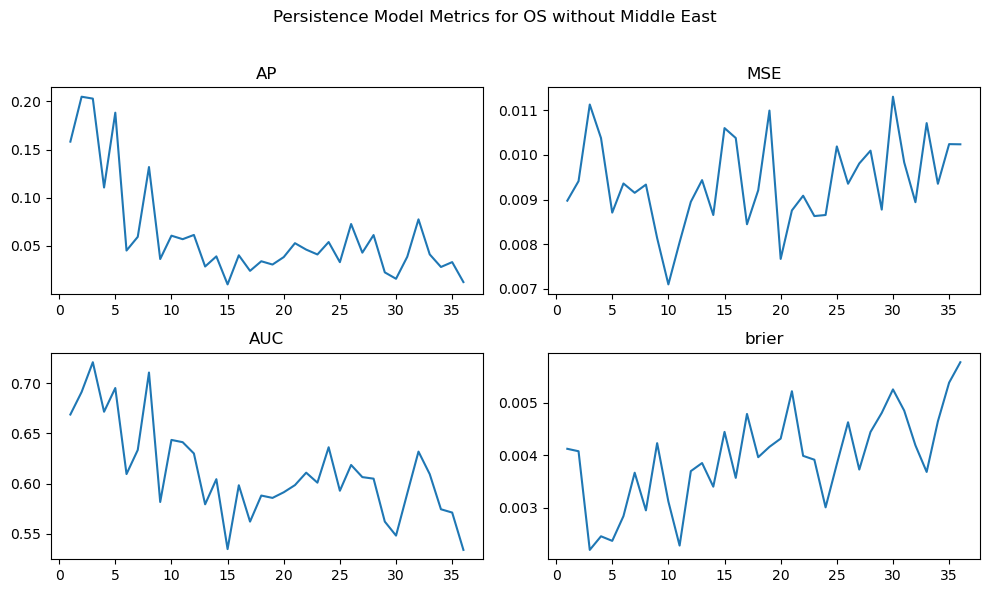

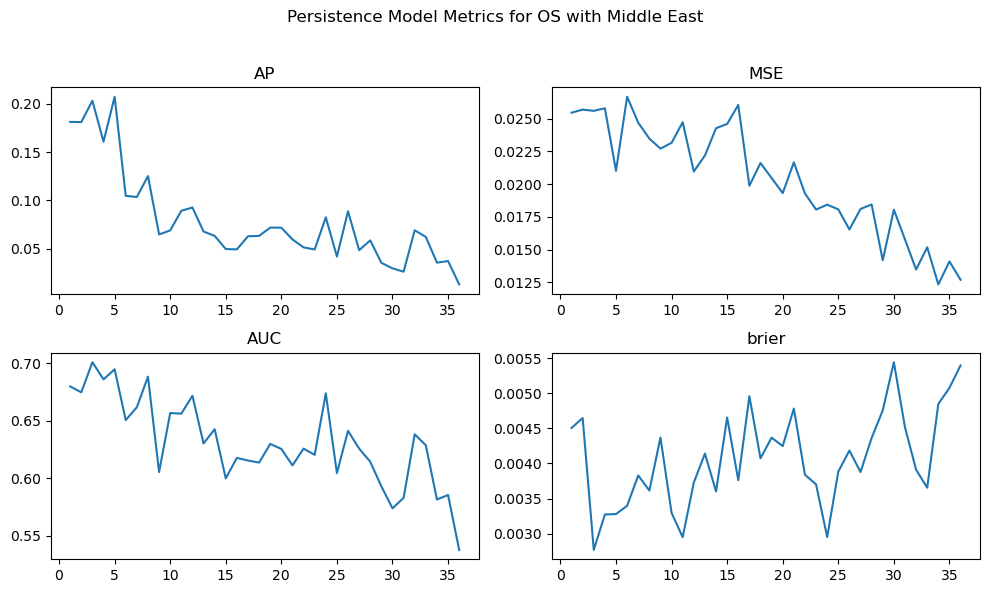

In [79]:
def plot_persistence_metrics(df_ap, df_auc, df_mse, df_brier, title="Persistence Model Metrics", region="SB", include_me=False):
    """
    Plot the step vs metrics for the persistence model across different metrics.

    Parameters:
    df_ap (pandas.DataFrame): DataFrame containing the AP metric over steps.
    df_auc (pandas.DataFrame): DataFrame containing the AUC metric over steps.
    df_mse (pandas.DataFrame): DataFrame containing the MSE metric over steps.
    df_brier (pandas.DataFrame): DataFrame containing the Brier score over steps.
    title (str): Title for the plot.
    region (str): Region identifier (e.g., "SB", "NS", "OS").
    include_me (bool): Whether the dataset includes the Middle East (True or False).

    Returns:
    None: Displays the plot.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot each metric on its respective subplot
    axs[0, 0].plot(df_ap["step"], df_ap["AP"], label="AP")
    axs[1, 0].plot(df_auc["step"], df_auc["AUC"], label="AUC")
    axs[0, 1].plot(df_mse["step"], df_mse["MSE"], label="MSE")
    axs[1, 1].plot(df_brier["step"], df_brier["brier"], label="brier")
    
    # Subplot titles
    axs[0, 0].set_title("AP")
    axs[1, 0].set_title("AUC")
    axs[0, 1].set_title("MSE")
    axs[1, 1].set_title("brier")
    
    # Super title with region and ME inclusion
    region_title = f"{region} with{'out' if not include_me else ''} Middle East"
    fig.suptitle(f"{title} for {region_title}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
    plt.show()

# Example usage:
# Assuming you have the DataFrames ready for different regions and ME inclusion

# SB without ME example
plot_persistence_metrics(
    df_ap_sb_no_me_persistence, 
    df_auc_sb_no_me_persistence, 
    df_mse_sb_no_me_persistence, 
    df_brier_sb_no_me_persistence, 
    title="Persistence Model Metrics", 
    region="SB", 
    include_me=False
)

# SB with ME example
plot_persistence_metrics(
    df_ap_sb_me_persistence, 
    df_auc_sb_me_persistence, 
    df_mse_sb_me_persistence, 
    df_brier_sb_me_persistence, 
    title="Persistence Model Metrics", 
    region="SB", 
    include_me=True
)

# NS without ME example
plot_persistence_metrics(
    df_ap_ns_no_me_persistence, 
    df_auc_ns_no_me_persistence, 
    df_mse_ns_no_me_persistence, 
    df_brier_ns_no_me_persistence, 
    title="Persistence Model Metrics", 
    region="NS", 
    include_me=False
)

# NS with ME example
plot_persistence_metrics(
    df_ap_ns_me_persistence, 
    df_auc_ns_me_persistence, 
    df_mse_ns_me_persistence, 
    df_brier_ns_me_persistence, 
    title="Persistence Model Metrics", 
    region="NS", 
    include_me=True
)

# OS without ME example
plot_persistence_metrics(
    df_ap_os_no_me_persistence, 
    df_auc_os_no_me_persistence, 
    df_mse_os_no_me_persistence, 
    df_brier_os_no_me_persistence, 
    title="Persistence Model Metrics", 
    region="OS", 
    include_me=False
)

# OS with ME example
plot_persistence_metrics(
    df_ap_os_me_persistence, 
    df_auc_os_me_persistence, 
    df_mse_os_me_persistence, 
    df_brier_os_me_persistence, 
    title="Persistence Model Metrics", 
    region="OS", 
    include_me=True
)

# Individual results

In [81]:
analyze_model_performance(df_ap_sb_me, metric_name, model_type="median", verbose=False)

Model(s) with the Median Brier: ['model_06_20240807_174827']
Brier for the Model with Median Performance: 0.4473540236555512
Standard Deviation of Ranked Brier: 0.014211853544277342




In [83]:
# load median model - manuuallly selected from the above analysis.  
PATH_df_output = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/df_sb_os_ns_output_36_testing_20240807_174827.pkl"

df_output = pd.read_pickle(PATH_df_output)

In [84]:
#The mean average precision with 3 decimal places
print(f"average precision {average_precision_score(df_output['y_true_binary_sb'], df_output['y_score_prob_sb']):.3f}")
print(f"average precision {average_precision_score(df_output['y_true_binary_os'], df_output['y_score_prob_os']):.3f}")
print(f"average precision {average_precision_score(df_output['y_true_binary_ns'], df_output['y_score_prob_ns']):.3f}")

#The mean squared error with 3 decimal places
print(f"mean squared error {mean_squared_error(df_output['y_true_sb'], df_output['y_score_sb']):.3f}")
print(f"mean squared error {mean_squared_error(df_output['y_true_os'], df_output['y_score_os']):.3f}")
print(f"mean squared error {mean_squared_error(df_output['y_true_ns'], df_output['y_score_ns']):.3f}")

average precision 0.431
average precision 0.175
average precision 0.331
mean squared error 0.024
mean squared error 0.003
mean squared error 0.007


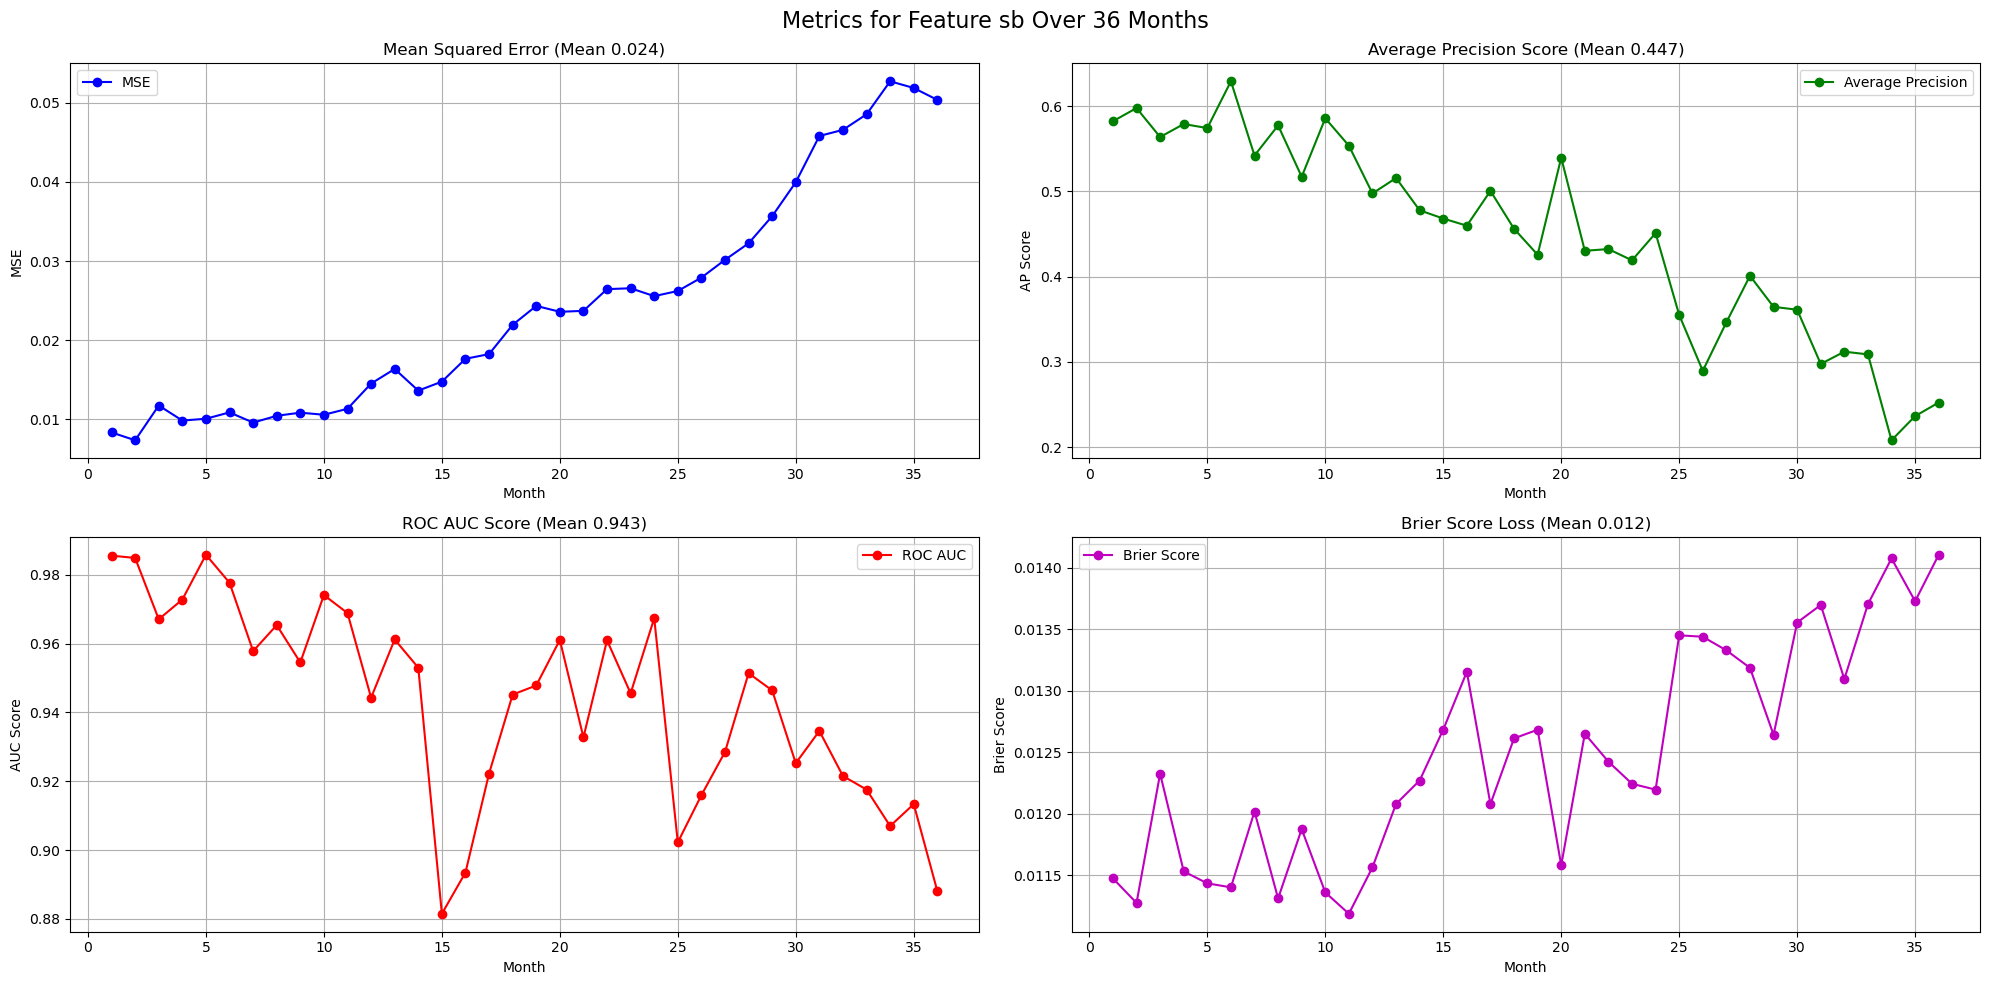

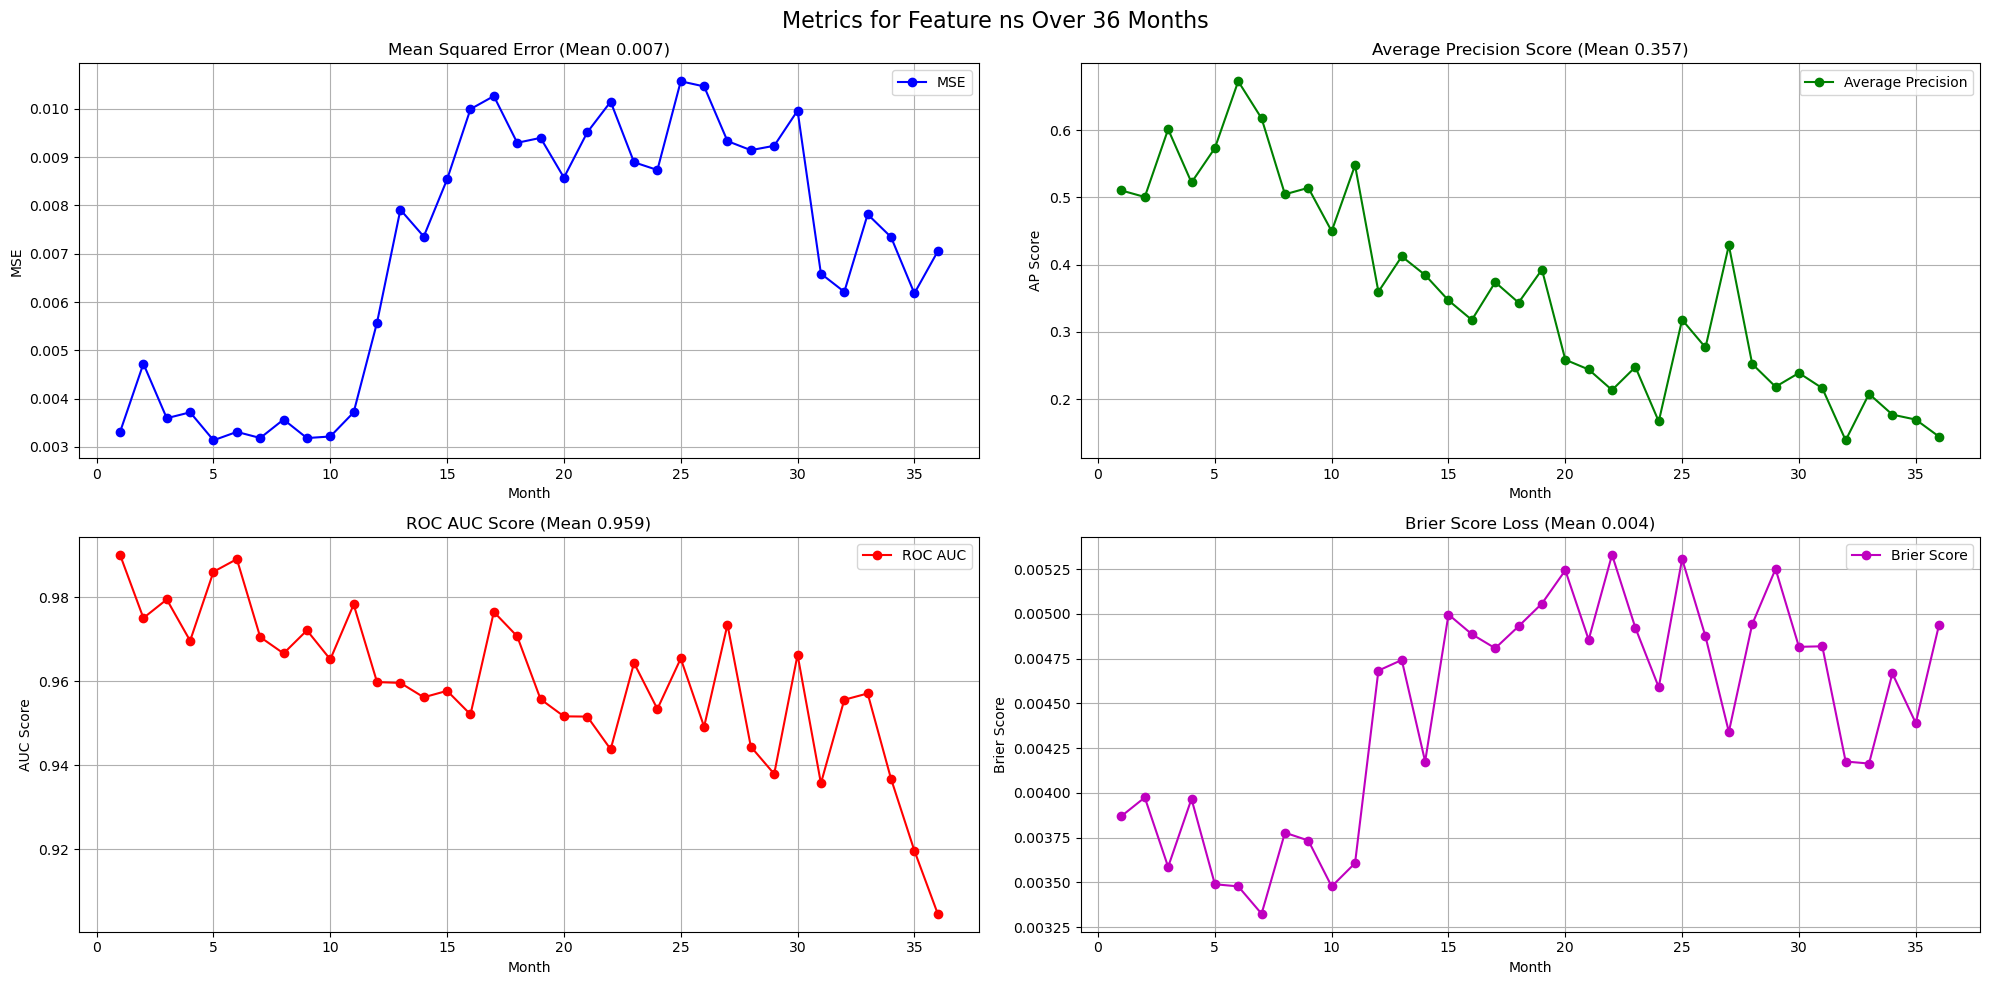

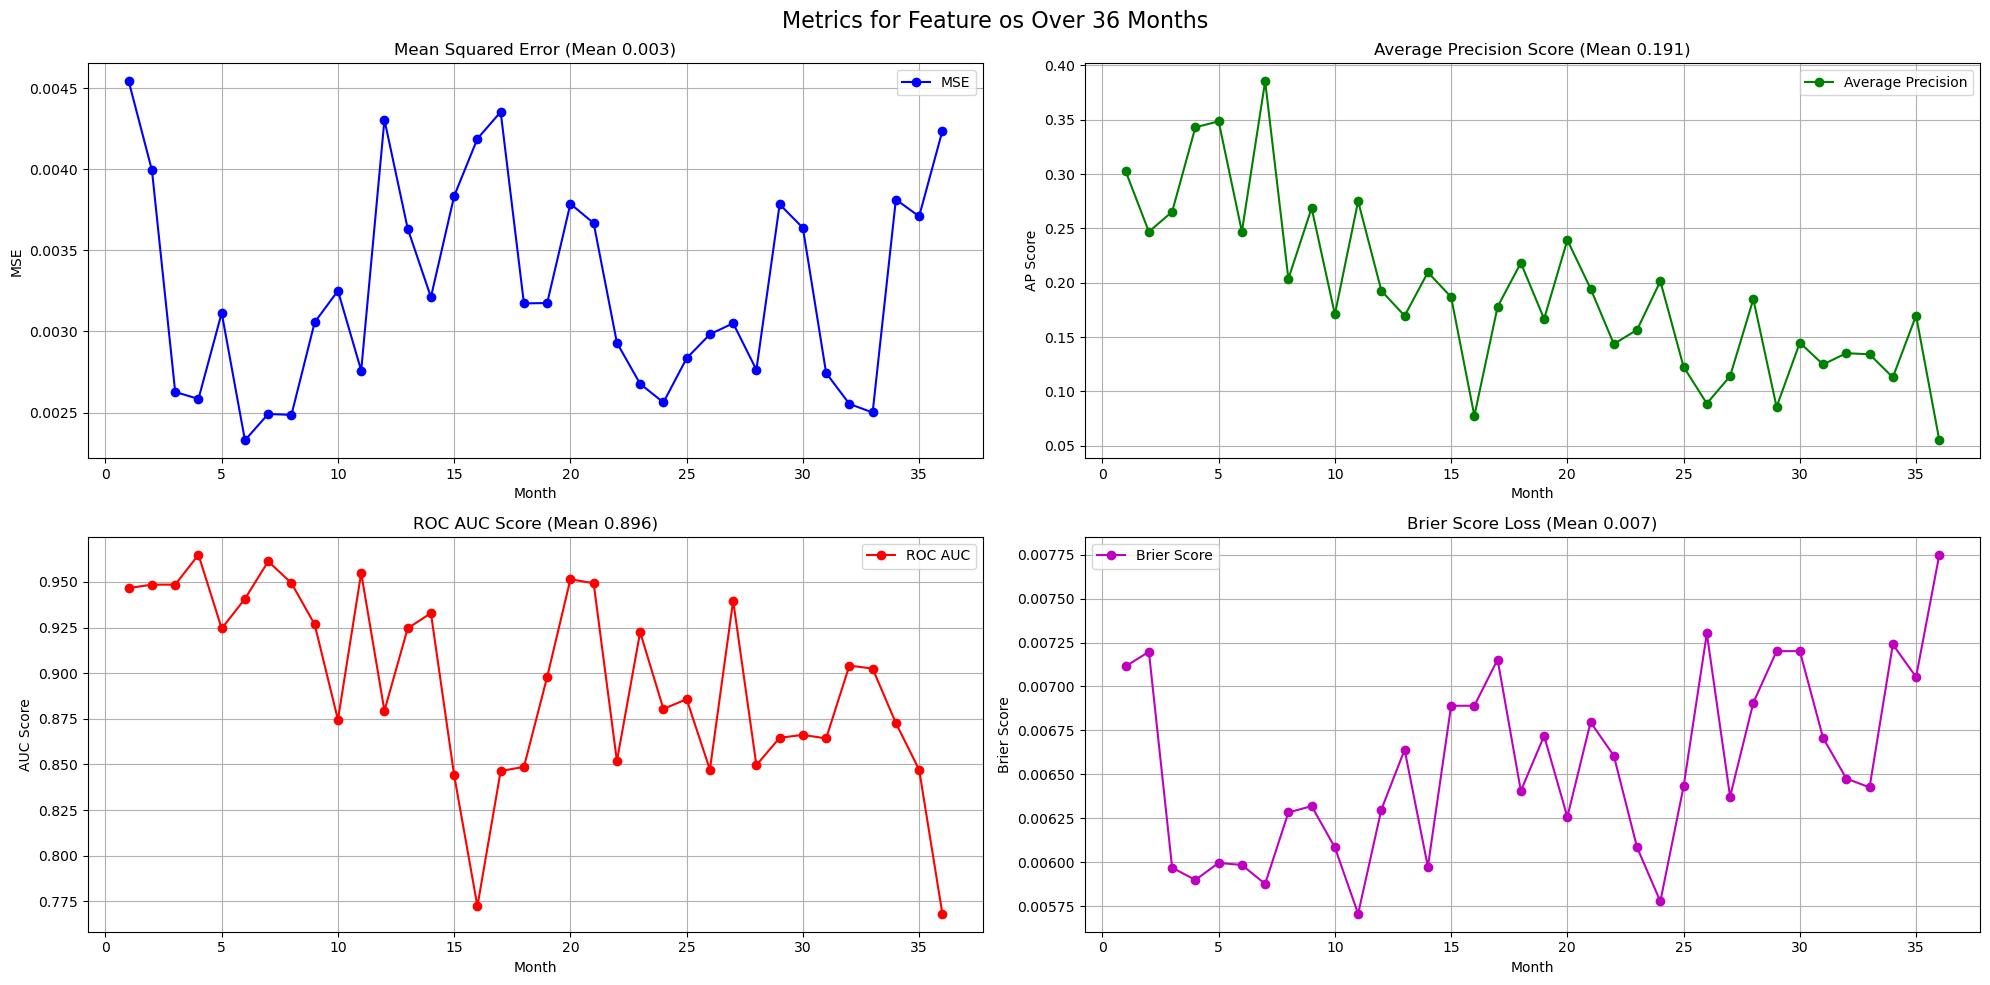

In [85]:
# tjek that the output df gives the right results

# Example usage:
plot_metrics(df_output, "sb")

# Example usage:
plot_metrics(df_output, "ns")

# Example usage:
plot_metrics(df_output, "os")

In [86]:
df_output

,y_score_sb,y_score_prob_sb,y_var_sb,y_var_prob_sb,y_true_sb,y_true_binary_sb,y_score_ns,y_score_prob_ns,y_var_ns,y_var_prob_ns,...,y_score_prob_os,y_var_os,y_var_prob_os,y_true_os,y_true_binary_os,pg_id,c_id,month_id,step,month
0,0.0,0.056519,0.0,0.021784,0.0,0,0.0,0.029181,0.0,0.011019,...,0.038764,0.0,0.014453,0.0,0,190494.0,89.0,433,1,1
1,0.0,0.072088,0.0,0.018446,0.0,0,0.0,0.050840,0.0,0.017706,...,0.048600,0.0,0.015328,0.0,0,190495.0,89.0,433,1,1
2,0.0,0.094022,0.0,0.022218,0.0,0,0.0,0.045373,0.0,0.012853,...,0.047279,0.0,0.011625,0.0,0,190496.0,89.0,433,1,1
3,0.0,0.024822,0.0,0.010635,0.0,0,0.0,0.018441,0.0,0.009593,...,0.022119,0.0,0.009654,0.0,0,190507.0,96.0,433,1,1
4,0.0,0.025891,0.0,0.010853,0.0,0,0.0,0.011858,0.0,0.007137,...,0.023327,0.0,0.009038,0.0,0,190508.0,96.0,433,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471955,0.0,0.007153,0.0,0.004419,0.0,0,0.0,0.002219,0.0,0.001483,...,0.014536,0.0,0.009800,0.0,0,80332.0,163.0,468,36,36
471956,0.0,0.011377,0.0,0.007559,0.0,0,0.0,0.003021,0.0,0.003331,...,0.014804,0.0,0.008420,0.0,0,79599.0,163.0,468,36,36
471957,0.0,0.008830,0.0,0.005719,0.0,0,0.0,0.003016,0.0,0.002511,...,0.018494,0.0,0.010046,0.0,0,79600.0,163.0,468,36,36
471958,0.0,0.010361,0.0,0.005793,0.0,0,0.0,0.002941,0.0,0.002336,...,0.015146,0.0,0.009210,0.0,0,79601.0,163.0,468,36,36


In [87]:
middle_east_c_id = [ 0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0, 218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0]
df_output_no_middle_east = df_output[~df_output["c_id"].isin(middle_east_c_id)].copy()

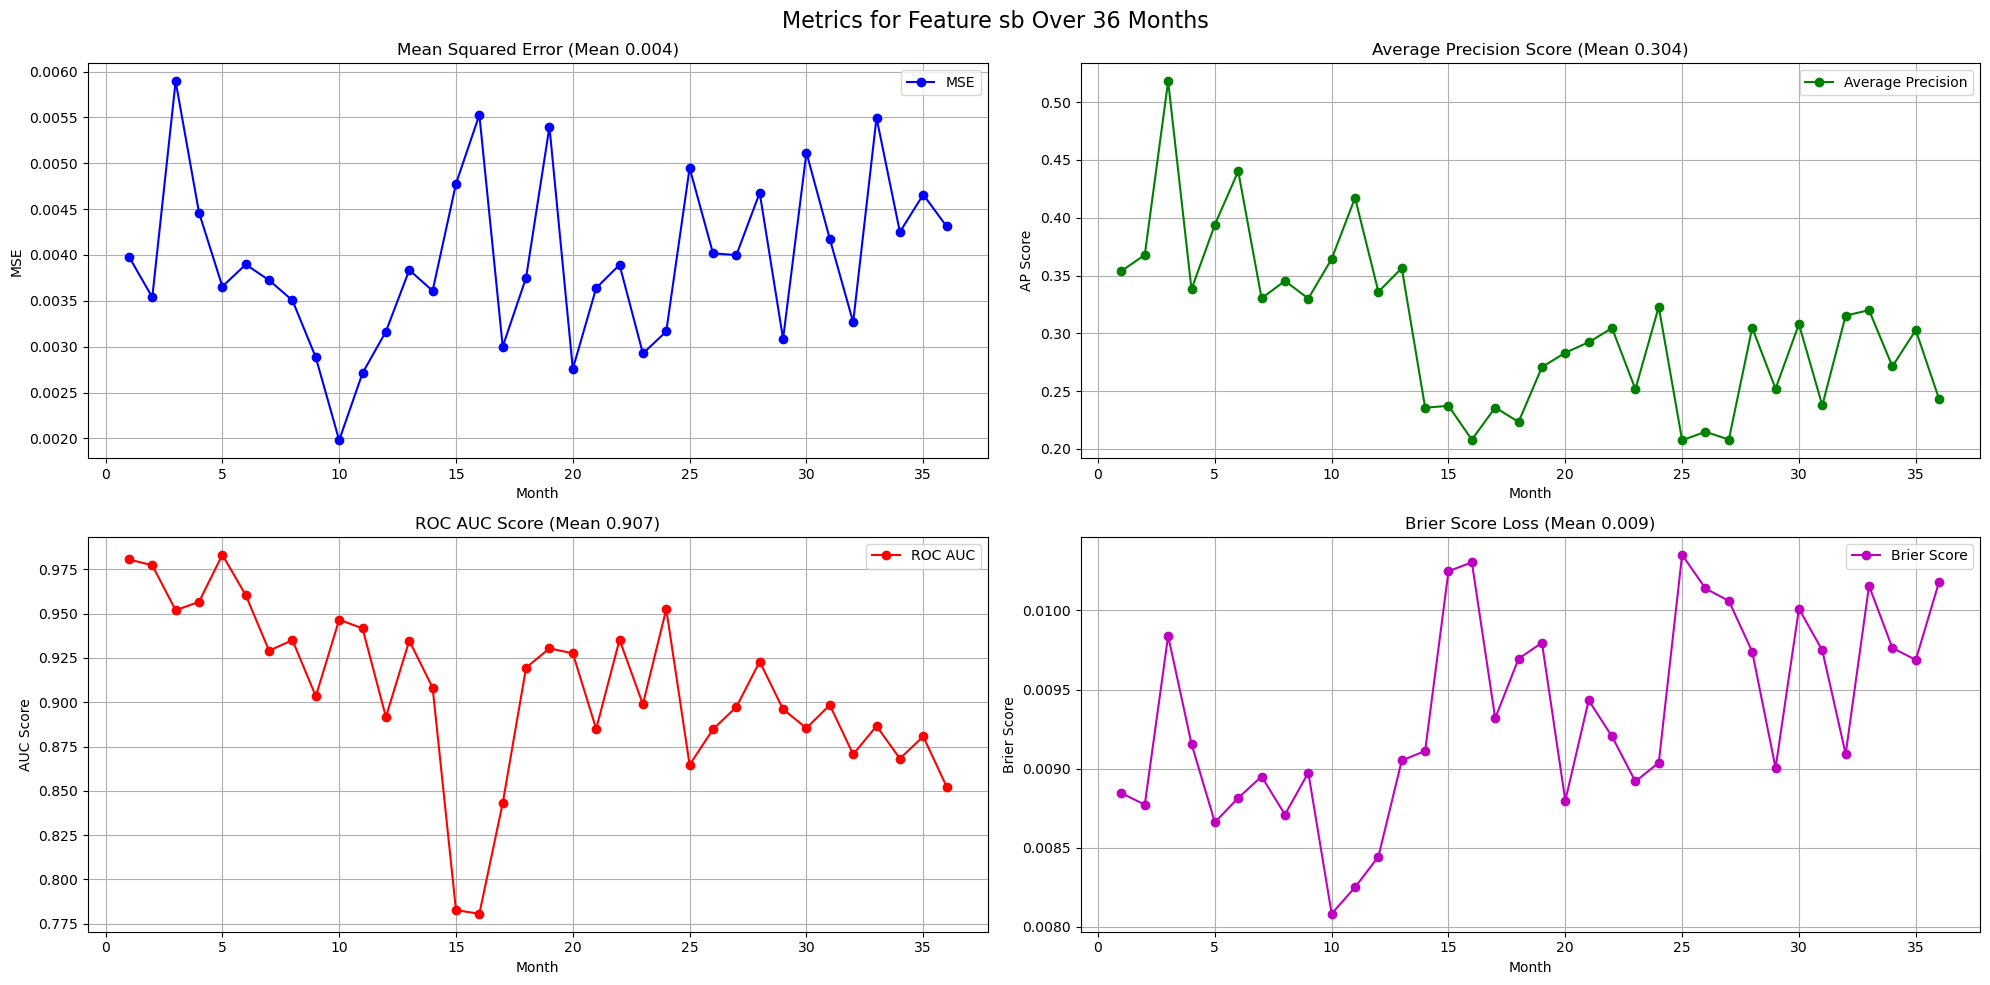

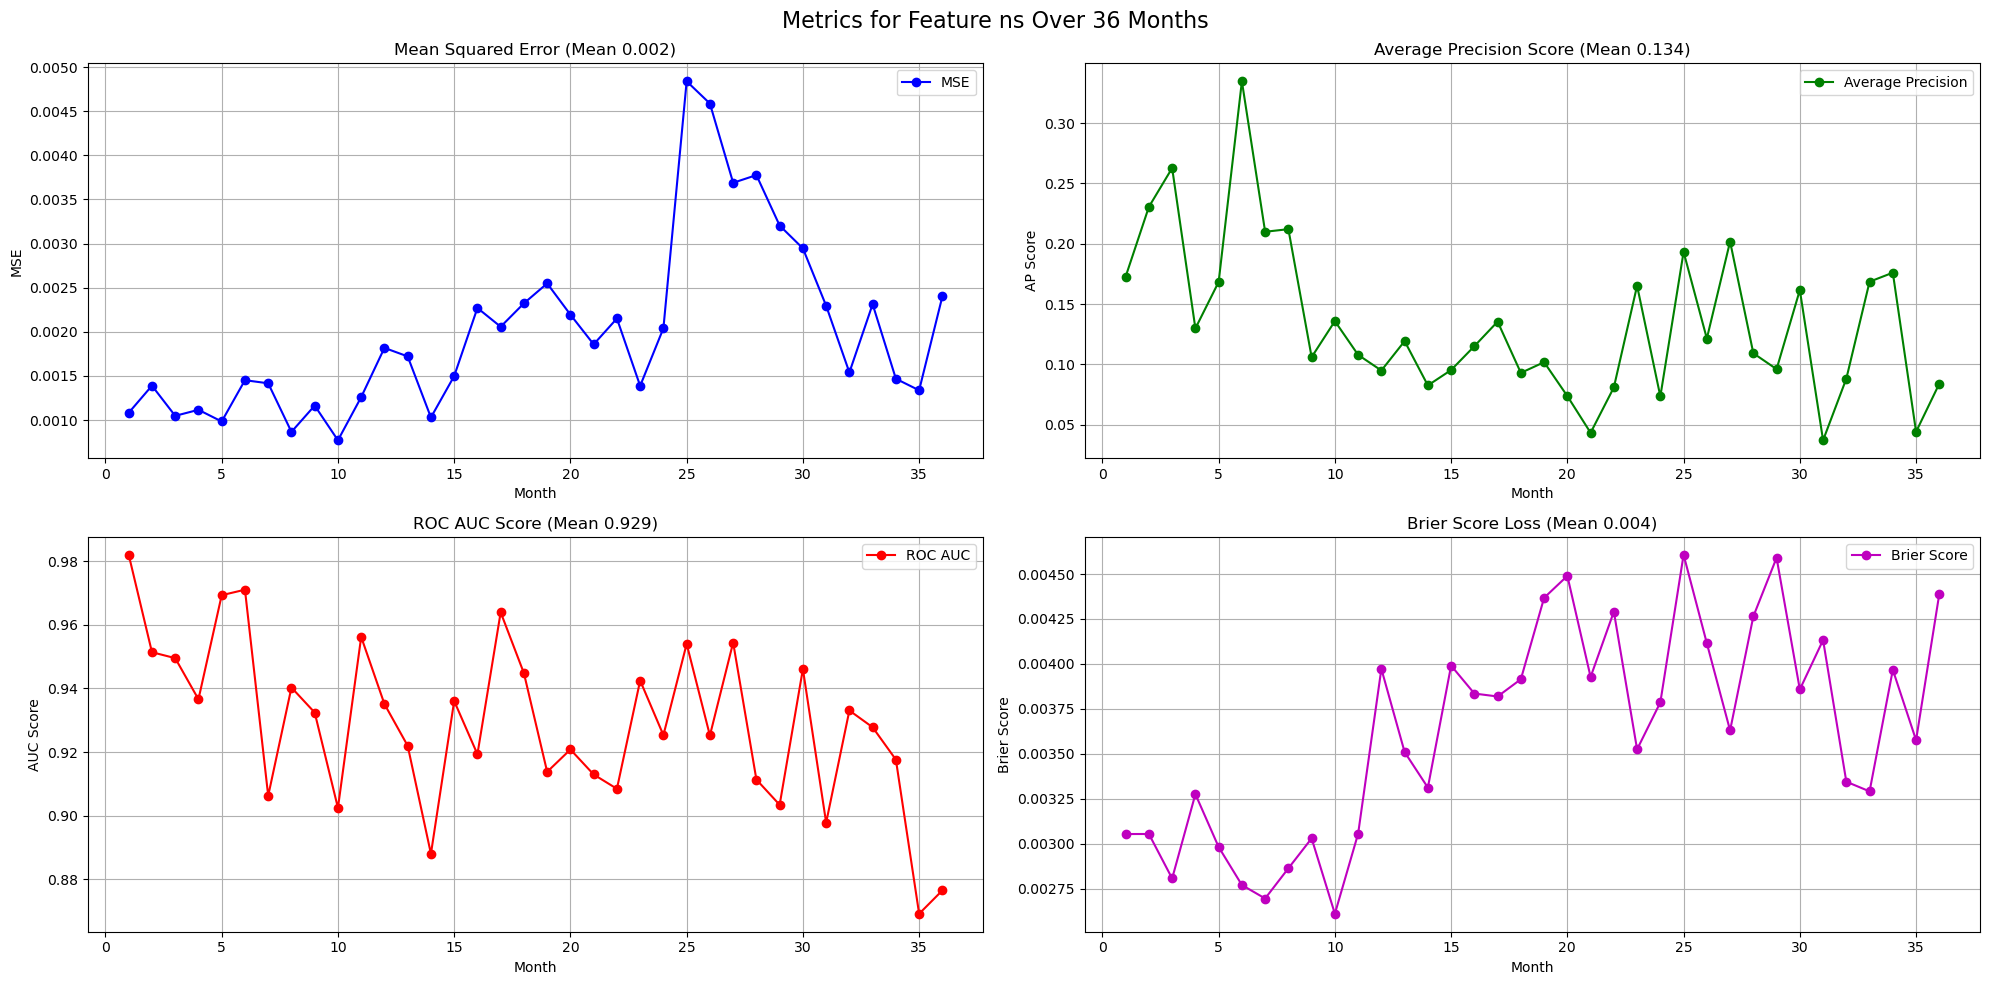

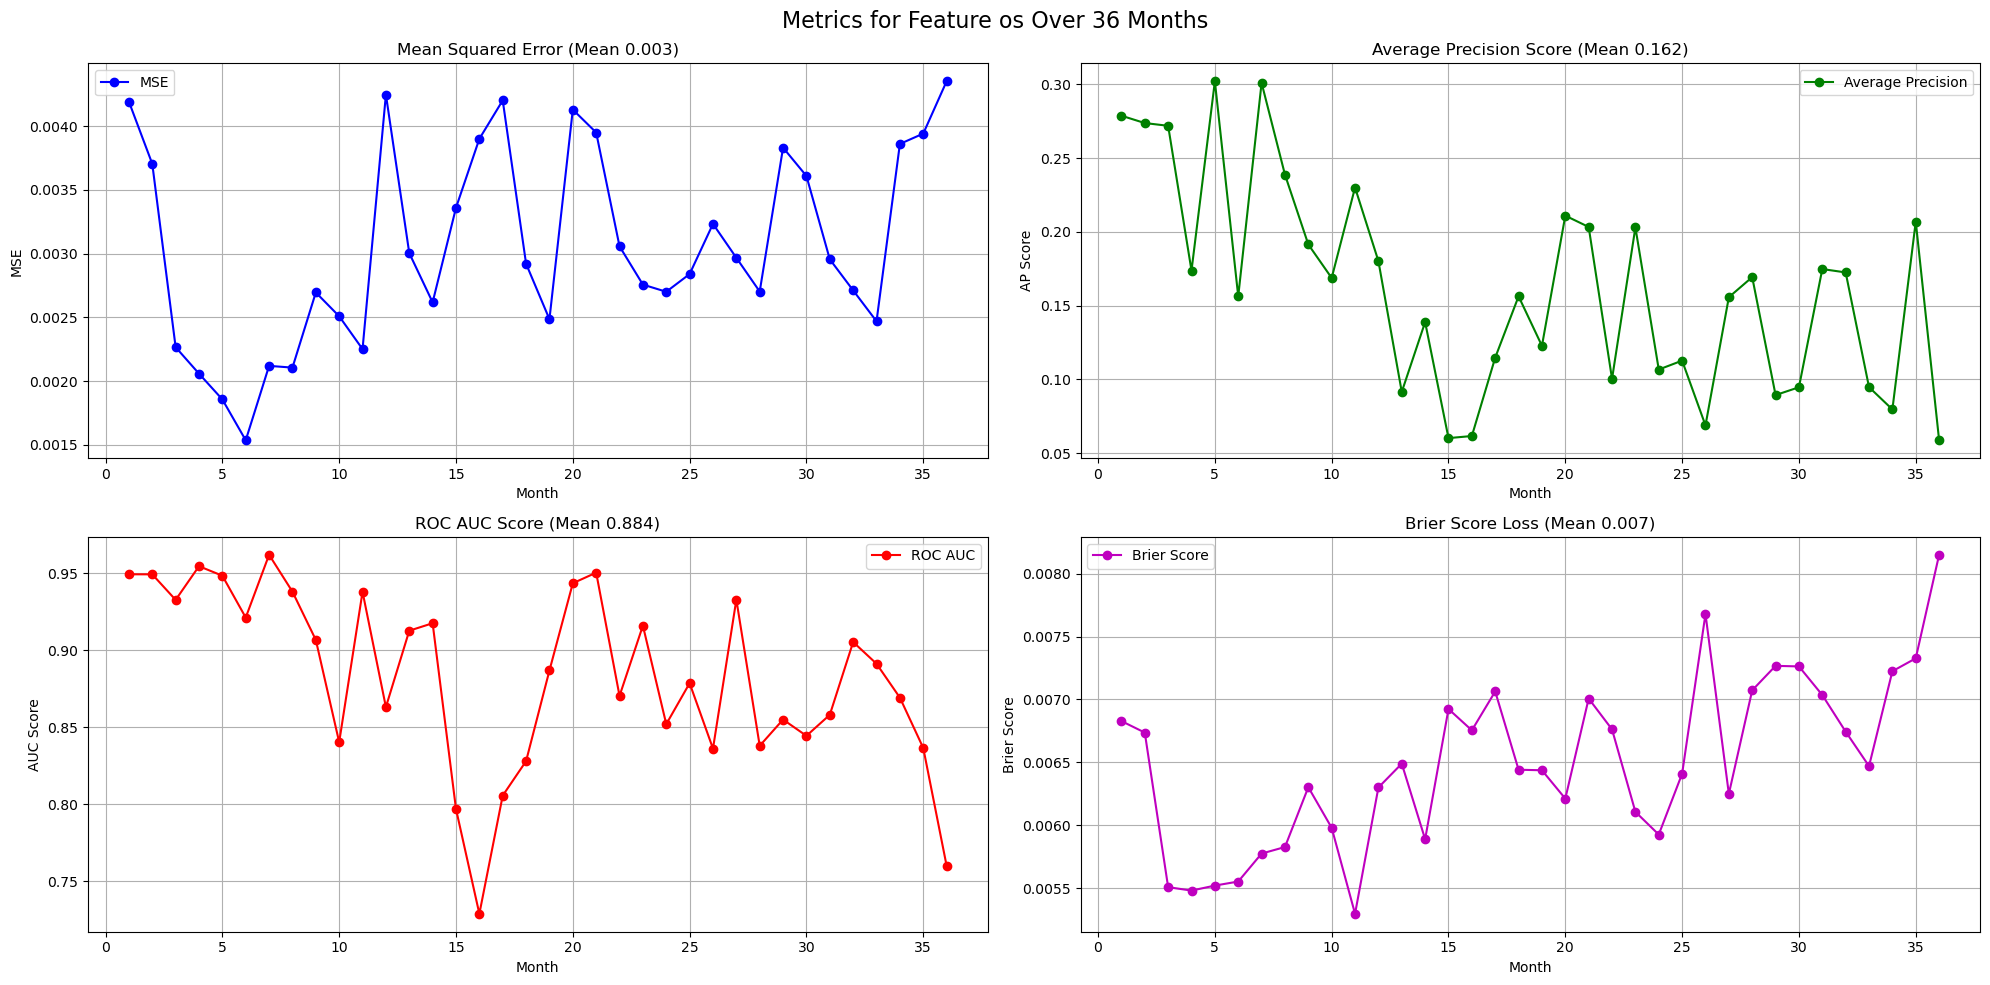

In [88]:
# tjek that the output df gives the right results

# Example usage:
plot_metrics(df_output_no_middle_east, "sb")

# Example usage:
plot_metrics(df_output_no_middle_east, "ns")

# Example usage:
plot_metrics(df_output_no_middle_east, "os")

# Now plots for the paper with the median model and the persitence model overlayed. 
(or just let that be part of the function above?)